In [1]:
library(tidyverse) # v2.0.0
library(tidygraph) # v1.3.1
library(ggrepel) # v0.9.6
library(vegan) # v2.8-0
library(visNetwork) # v2.1.4
library(igraph) # v2.1.1
library(scales) # v1.4.0
library(ggraph) # v2.2.1

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter


Loading required package: permute


Attaching package: ‘igraph’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:permute’:

    permute


The following object is masked from ‘package:tidygraph’:

    groups


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following object

Number of selected ASVs: 59 
ASVs:  0ba6509a62addc6651135eaca12d6ea5, ea81aa4ee9c3af4be0f11d982831fc57, 7a86a5a502cc47c38ad1d4f8b85a46a7, bfe5247872ee029ef526b030b978b13a, 58b2df195354cee42fb067f5c01bf437, a6581fbd9e9dc38911bfe4a3106ea23e, cf34eabeb0e558ea91a7c670ddee8846, 8b355df02c3e115ae74f25b9fd025028, 6947d8c09116da04f3f269034fe3bd27, 5d399d1b23cdad4d40044a65961b2131, 1f0503db6b3674f65719ef8a56cb6424, b865a79dd61a7303c3828e7fdb8a6db4, f8cda321693dfe419cbd85697976da06, aa5abd481bddf81b41a126f95ff90289, 164079c18ae51d08bd8c96fedd28280c, e7dce53e039f666b9ab56e8ccb528f9f, 69aa77280568ef0d6f372651ac69b1fa, 54ef06549d0aba772fbdb074eb0f6927, a273ca62659af549ac466e6358bd237c, cec766696c6d665b7cdff4dd7461a656 


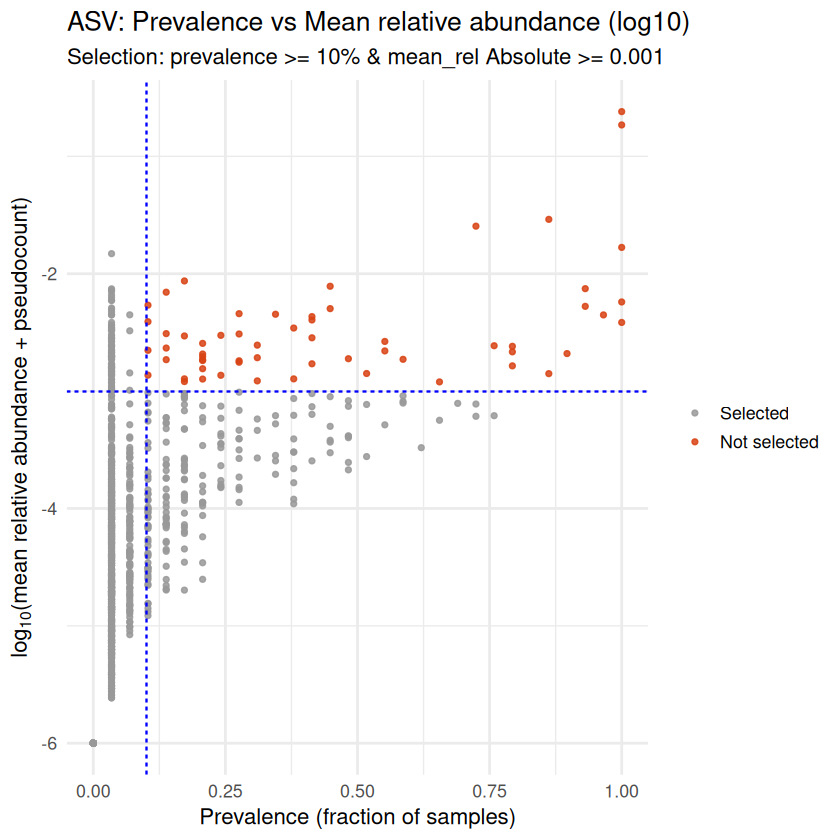

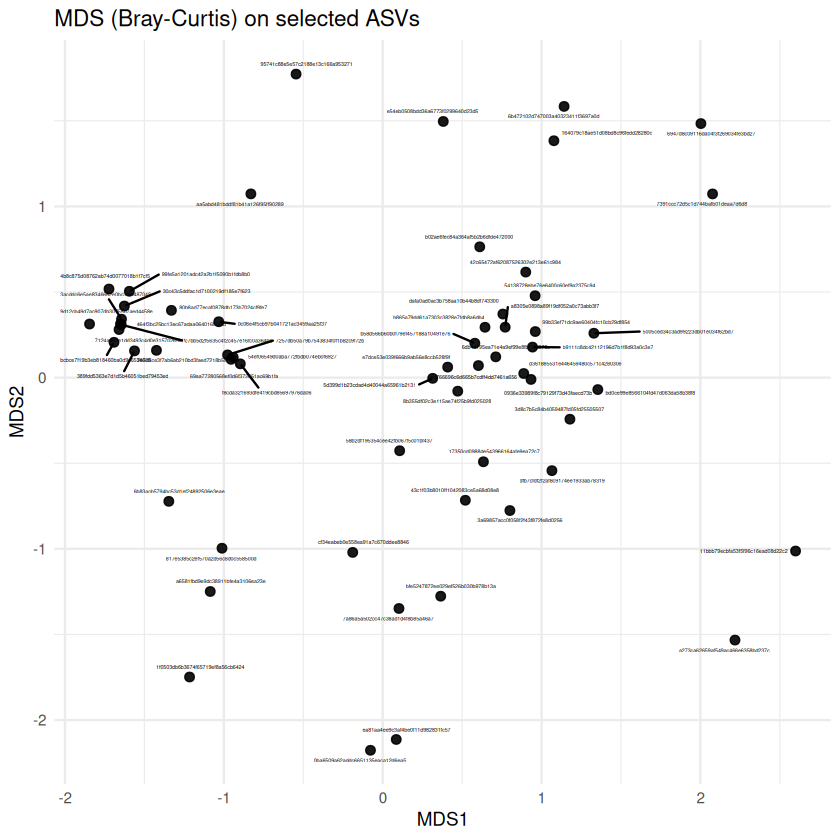

In [2]:
ASV_table <- read.table("../ASV table.txt",sep="\t",stringsAsFactors=FALSE,header=1,row.names=1) # ASVs x Samples

metadata <- read.table("metadata.txt",sep="\t",stringsAsFactors=FALSE,header=1,row.names=1) # Samples x Characteristics

common_samples <- intersect(colnames(ASV_table), rownames(metadata))

ASV_table <- ASV_table[, common_samples, drop = FALSE]

asv_tab <- t(ASV_table)

prevalence_cut <- 0.10         # 10 %
mean_rel_cut_type <- "absolute"
mean_rel_cut_absolute <- 0.001  # mean relative abundance 1 %
pseudocount <- 1e-6

zero_row_idx <- which(rowSums(asv_tab, na.rm=TRUE) == 0)
if(length(zero_row_idx) > 0){
  warning("Samples with a total count of zero were detected and removed: ", paste(rownames(asv_tab)[zero_row_idx], collapse=", "))
  asv_tab <- asv_tab[-zero_row_idx,, drop=FALSE]
}

relab <- sweep(asv_tab, 1, rowSums(asv_tab), FUN = "/")  # samples x ASV

prev <- colSums(asv_tab > 0, na.rm=TRUE) / nrow(asv_tab)
mean_rel <- colMeans(relab, na.rm=TRUE)
mean_rel_log10 <- log10(mean_rel + pseudocount)

asv_stats <- tibble(
  ASV = colnames(asv_tab),
  prevalence = as.numeric(prev),
  mean_rel = as.numeric(mean_rel),
  mean_rel_log10 = as.numeric(mean_rel_log10)
)

if(tolower(mean_rel_cut_type) == "absolute"){
  mean_rel_cutoff_value <- mean_rel_cut_absolute
  cutoff_label <- paste0("Absolute >= ", mean_rel_cutoff_value)
} else {
  stop("The mean_rel_cut_type was set to 'absolute'")
}

asv_stats <- asv_stats %>%
  mutate(selected = (prevalence >= prevalence_cut) & (mean_rel >= mean_rel_cutoff_value))

selected_asvs <- asv_stats %>% filter(selected) %>% arrange(desc(mean_rel)) %>% pull(ASV)

cat("Number of selected ASVs:", length(selected_asvs), "\n")
if(length(selected_asvs) > 0) cat("ASVs: ", paste(head(selected_asvs, 20), collapse = ", "), "\n")


p <- ggplot(asv_stats, aes(x = prevalence, y = mean_rel_log10)) +
  geom_point(aes(color = selected), size = 1, alpha = 0.85) +
  scale_color_manual(values = c("TRUE" = "#D84315", "FALSE" = "grey60"), labels = c("Selected", "Not selected")) +
  geom_vline(xintercept = prevalence_cut, linetype = "dashed", color = "blue") +
  geom_hline(yintercept = log10(mean_rel_cutoff_value + pseudocount), linetype = "dashed", color = "blue") +
  labs(x = "Prevalence (fraction of samples)",
       y = expression(log[10]*"(mean relative abundance + pseudocount)"),
       color = NULL,
       title = "ASV: Prevalence vs Mean relative abundance (log10)",
       subtitle = paste0("Selection: prevalence >= ", prevalence_cut*100, "% & mean_rel ", cutoff_label)) +
  theme_minimal(base_size = 13)

print(p)

write_csv(asv_stats %>% filter(selected), "ASV_selected_by_prevalence_meanrel_absolute.csv")
ggsave(filename = "./Prevalence_RA_scatter_plot.pdf", plot = p, width = 9, height = 7, dpi = 300)

d <- vegdist(t(relab[, selected_asvs]), method = "bray")

write.table(t(asv_tab[, selected_asvs]),  "Selected_ASV_table.txt",  sep = "\t", row.names = TRUE)

m <- metaMDS(d, k = 2, trymax = 40, autotransform = FALSE, trace = FALSE)

coords <- as.data.frame(scores(m, display = "sites"))
coords$sample <- rownames(coords)

p <- ggplot(coords, aes(x = NMDS1, y = NMDS2)) +
  geom_point(size = 2, alpha = 0.9) +
  geom_text_repel(aes(label = sample), size = 1, max.overlaps = 20) +
  theme_minimal() +
  labs(title = "MDS (Bray-Curtis) on selected ASVs",
       x = "MDS1", y = "MDS2")

print(p)

ggsave("MDS_selected_ASVs.pdf", p, width = 7, height = 6, dpi = 300)

Warning message:
“`guide_colourbar()` cannot be used for edge_colour.
ℹ Use one of colour, color, or fill instead.”
Warning message:
“`guide_colourbar()` cannot be used for edge_colour.
ℹ Use one of colour, color, or fill instead.”


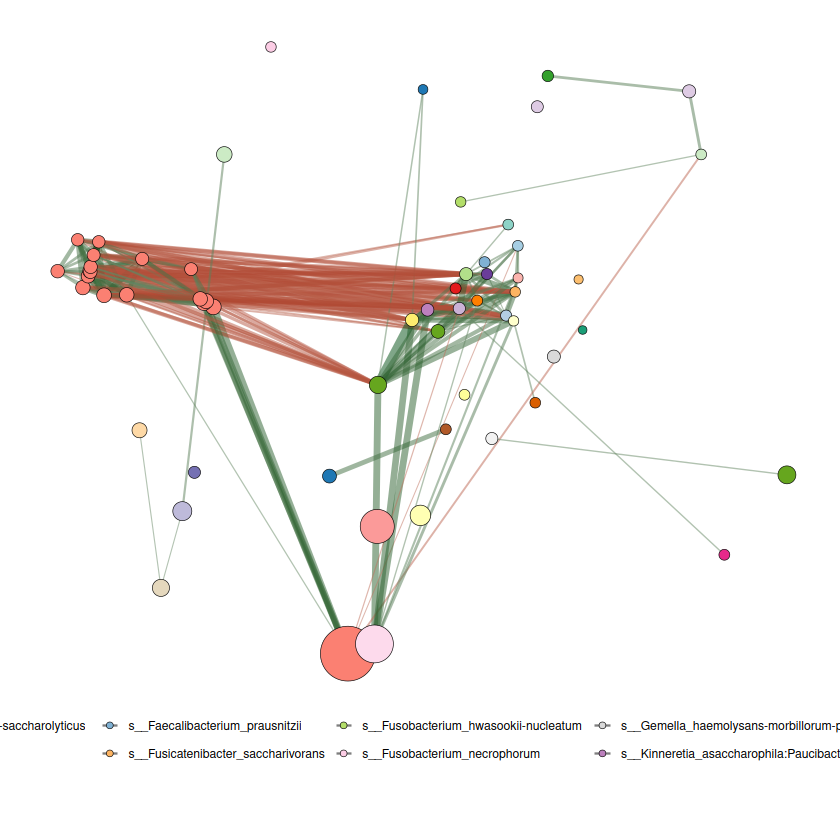

In [4]:
#The selected ASV table generated in the previous step was used as input for FastSpar to compute SparCC correlation coefficients and P values with 1,000 bootstrap iterations and default settings.

cor_file  <- "./fastspar_output/SparCC_cor.tsv"    # FastSpar correlation output
pval_file <- "./fastspar_output/pvalues.tsv"  # FastSpar p-value output (bootstrap)
coords_df <- coords       # data.frame with columns: ASV, x, y (MDS coords)
coords_df$ASV <- rownames(coords)
asv_counts <- asv_tab[, selected_asvs] 
tax <- "asv2species.txt" # 1st column: ASVs and 2nd column: species names

rho_thresh <- 0.5
pval_thresh <- 0.05
edge_top_n <- NULL

cor_mat <- as.matrix(read.table(cor_file, header = TRUE, row.names = 1, sep = "\t", check.names = FALSE))
p_mat   <- as.matrix(read.table(pval_file, header = TRUE, row.names = 1, sep = "\t", check.names = FALSE))

tax <- read.table(tax, header=TRUE, sep="\t", stringsAsFactors=FALSE)

taxa <- intersect(rownames(cor_mat), colnames(cor_mat))
cor_mat <- cor_mat[taxa, taxa]
p_mat   <- p_mat[taxa, taxa]

edges_df <- as.data.frame(as.table(cor_mat), stringsAsFactors = FALSE)
colnames(edges_df) <- c("from", "to", "rho")
edges_df <- edges_df %>% filter(from < to)

# add P values
p_long <- as.data.frame(as.table(p_mat), stringsAsFactors = FALSE)
colnames(p_long) <- c("from","to","pval")
p_long <- p_long %>% filter(from < to)
edges_df <- left_join(edges_df, p_long, by = c("from","to"))

# filter by thresholds
edges_df <- edges_df %>%
  mutate(abs_rho = abs(rho)) %>%
  filter(abs_rho >= rho_thresh, pval <= pval_thresh)

if(!is.null(edge_top_n)){
  edges_df <- edges_df %>% arrange(desc(abs_rho)) %>% slice_head(n = edge_top_n)
}

mean_abund <- colMeans(as.matrix(asv_counts)[, taxa, drop=FALSE], na.rm = TRUE)

nodes_df <- tibble(id = taxa,
                   label = taxa,
                   x = coords_df$NMDS1[match(taxa, coords_df$ASV)],
                   y = coords_df$NMDS2[match(taxa, coords_df$ASV)],
                   value = mean_abund[match(taxa, names(mean_abund))])

if(!is.null(tax)){
  nodes_df <- nodes_df %>%
    left_join(tax %>% rename(id = ASV), by = "id") %>%
    mutate(title = ifelse(is.na(Species),
                          paste0("<b>", id, "</b><br>mean_abund=", signif(value,3)),
                          paste0("<b>", Species, "</b><br>", id, "<br>mean_abund=", signif(value,3))))
}

nodes_df <- nodes_df %>%
  mutate(value = rescale(value, to = c(10, 40), from = range(value, na.rm = TRUE)))

edges_vis <- edges_df %>%
  mutate(from = as.character(from), to = as.character(to),
         rho = rho,
         width = rescale(abs_rho, to = c(1, 8)),
         color = ifelse(rho > 0, "darkgreen", "red"),
         title = paste0("rho=", round(rho,3), "<br>p=", signif(pval,3))
  ) %>%
  dplyr::select(from, to, rho, width, color, title)


valid_nodes <- nodes_df %>% filter(!is.na(x) & !is.na(y))
valid_ids <- valid_nodes$id
edges_vis <- edges_vis %>% filter(from %in% valid_ids & to %in% valid_ids)

nodes_vis <- valid_nodes %>% dplyr::select(id, label, title, value, x, y, Species)

valid_ids <- nodes_vis$id
edges_vis2 <- edges_vis %>% filter(from %in% valid_ids & to %in% valid_ids)

rho_thresh <- 0.5
pval_thresh <- 0.05
edges_vis2 <- edges_vis2 %>%
  mutate(abs_rho = abs(rho)) %>%
  filter(abs_rho >= rho_thresh)
if("pval" %in% colnames(edges_vis2)){
  edges_vis2 <- edges_vis2 %>% filter(pval <= pval_thresh)
}

g <- graph_from_data_frame(d = edges_vis2 %>% dplyr::select(from,to,rho),
                           vertices = nodes_vis %>% rename(name = id),
                           directed = FALSE)

vseq <- V(g)$name
layout_mat <- nodes_vis %>%
  filter(id %in% vseq) %>%
  arrange(match(id, vseq)) %>% 
  dplyr::select(x,y) %>%
  as.matrix()

if("value" %in% colnames(nodes_vis)){
  node_attr <- nodes_vis %>% filter(id %in% vseq) %>% arrange(match(id, vseq))
  node_size <- rescale(node_attr$value, to = c(3, 10))
} else {
  node_size <- rescale(degree(g, mode="all"), to = c(3, 10))
}

if("Species" %in% colnames(nodes_vis)){
  node_color <- node_attr$Species
} else {
  node_color <- "ASV"
}

names(node_color) <- V(g)$name

g_edges <- as_data_frame(g, what = "edges") %>%
  mutate(a = pmin(from, to), b = pmax(from, to))

edges_vis2_prepared <- edges_vis2 %>%
  mutate(a = pmin(from, to), b = pmax(from, to))

edges_joined <- left_join(g_edges, edges_vis2_prepared %>% dplyr::select(a, b, rho), by = c("a", "b"))

E(g)$weight <- edges_joined$rho.x

E(g)$absw <- abs(E(g)$weight)
E(g)$color <- ifelse(E(g)$weight > 0, "darkgreen", "darkred")
E(g)$width <- rescale(E(g)$absw, to = c(0.3, 2.5), from = range(E(g)$absw, na.rm=TRUE))

tg <- as_tbl_graph(g) %>%
activate(nodes) %>%
mutate(deg = centrality_degree(),
cluster = as.factor(group_louvain()))

size_breaks <- pretty(range(node_size, na.rm=TRUE), n=3)

p <- ggraph(tg, layout = "manual", x = layout_mat[,1], y = layout_mat[,2]) +
  geom_edge_link(aes(edge_width = abs(weight), edge_color = weight),
                 alpha = 0.5, show.legend = TRUE) +
  scale_edge_color_gradient2(
    low = "#9a0000", mid = "grey80", high = "#004e13",
    midpoint = 0, name = "Correlation"
  ) +
  scale_edge_width(range = c(0.2, 2)) +
  geom_node_point(aes(size = node_size, fill = node_color),
                  shape = 21, color = "black", stroke = 0.2) +
  scale_size_continuous(range = c(2, 15), name = "RA", breaks = size_breaks, labels = signif(size_breaks, 3)) +
  scale_fill_manual(
    values = c(RColorBrewer::brewer.pal(12,'Paired'), RColorBrewer::brewer.pal(12,'Set3'), RColorBrewer::brewer.pal(9,'Pastel1'), RColorBrewer::brewer.pal(8,'Dark2')),
    name = "Community"
  ) +
  theme_minimal(base_size = 11) +
  theme(
    legend.position = "bottom",
    legend.text = element_text(size = 7),
    legend.key.size = unit(0.4, "cm"),
    panel.grid = element_blank(),
    axis.text = element_blank(),
    axis.title = element_blank(),
    plot.margin = margin(10,10,10,10)
  ) +
  guides(
    size = guide_legend(nrow=1, override.aes=list(shape=21, fill="grey80",colour="black", stroke=0.2), title.position="top"),
    edge_color = guide_colorbar(title.position = "top", barwidth = unit(6, "cm")),
    fill = guide_legend(nrow = 2),
    edge_width = guide_legend(title.position = "top")
  )

ggsave("Network_ggraph.pdf", p, width = 10, height = 10, dpi = 300)
print(p)